Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [62]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization.batch_normalization import BatchNormalization
from glob import glob

In [63]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [104]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/upgrad'
data_dir_root_train = pathlib.Path(root_path + '/Train')
data_dir_root_test = pathlib.Path(root_path + '/Test')

data_dir_train = pathlib.Path(data_dir_root_train)
data_dir_test = pathlib.Path(data_dir_root_test)

In [105]:
# lets check the count of images in each folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [106]:
# initialize the variables
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [107]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                   subset="training",validation_split=0.2,label_mode='categorical',seed=123)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [108]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',subset="validation",validation_split=0.2,seed=123)
val_ds 

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [109]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

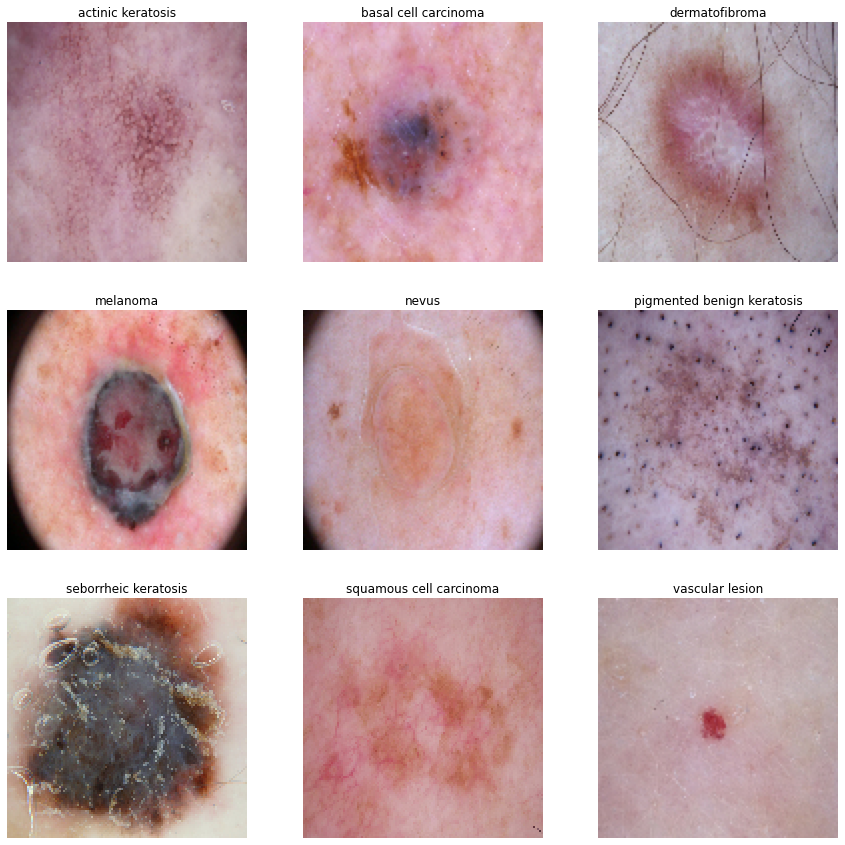

In [110]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(120,120)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [111]:
## lets see the count of all images with its classes
def class_image_count(directory):
    
    #count number of image in each classes
    cnt= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            cnt.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,cnt)),columns =['Classes', 'No. of Images'])

df = class_image_count(data_dir_train)
df


,Classes,No. of Images
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


In [112]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [116]:
### lets use Softmax activation function with categorical_crossentropy as loss function
input_shape = (180,180,3)
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# third conv layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_211 (ModuleW  (None, 178, 178, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_212 (ModuleW  (None, 176, 176, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_213 (ModuleW  (None, 88, 88, 32)       0         
 rapper)                                                         
                                                                 
 module_wrapper_214 (ModuleW  (None, 86, 86, 64)       18496     
 rapper)                                             

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [119]:
### We used categorical_crossentropy as the loss function as we are tring to solve a classification problem
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [120]:
# View the summary of all layers
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_211 (ModuleW  (None, 178, 178, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_212 (ModuleW  (None, 176, 176, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_213 (ModuleW  (None, 88, 88, 32)       0         
 rapper)                                                         
                                                                 
 module_wrapper_214 (ModuleW  (None, 86, 86, 64)       18496     
 rapper)                                             

### Train the model

In [115]:
# lets try to fit the created model with 20 epochs
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 639s 2s/step - loss: 2.0532 - accuracy: 0.2015 - val_loss: 1.9228 - val_accuracy: 0.2371
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9053 - accuracy: 0.3030 - val_loss: 1.7867 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.7131 - accuracy: 0.4023 - val_loss: 1.7859 - val_accuracy: 0.3400
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5962 - accuracy: 0.4202 - val_loss: 1.5468 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5636 - accuracy: 0.4347 - val_loss: 1.4674 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5516 - accuracy: 0.4531 - val_loss: 1.4486 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4202 - accuracy: 0.4961 - val_loss: 1.4039 - val_accuracy: 0.5011
Epoch 8/20
56

### Visualizing training results

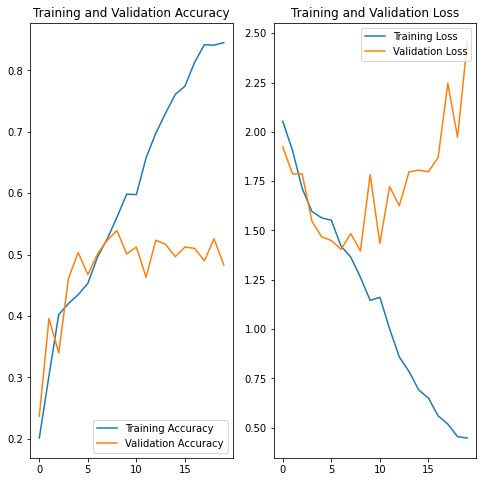

In [117]:
# lets see a graph of how the training and validation values perfomred for selected model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

In [121]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)



14/14 [==============================] - 0s 22ms/step - loss: 2.1867 - accuracy: 0.1700
Training Accuracy:  0.1902901828289032
Validation Accuracy:  0.1700223684310913
Loss:  2.186034917831421
Validation Loss 2.1867220401763916


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Model Underfitting :
if the accuracy on the validation set is higher than the accuracy on the training set. Additionally, if the whole model performs bad this is also called underfitting

### Model Overfitting :
Your training accuracy will be higher than the accuracy on the validation/test set


### Result : As we can see the model is Overfitting, because the Training accuracy is higher than the validation accuracy

Steps for reducing overfitting:

1) Add more data
2) Use data augmentation
3) Use architectures that generalize well
4) Add regularization (mostly dropout, L1/L2 regularization are also possible)
5) Reduce architecture complexity.

In [122]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

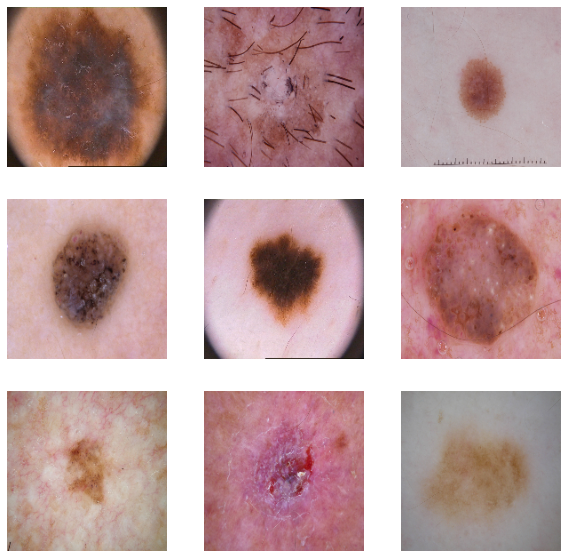

In [123]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    
    


### Todo:
### Create the model, compile and train the model


In [124]:
## AS we have the model overfitting we will use some drop outs at each convolution

## Your code goes here
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# third conv layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_223 (ModuleW  (None, 178, 178, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_224 (ModuleW  (None, 176, 176, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_225 (ModuleW  (None, 88, 88, 32)       0         
 rapper)                                                         
                                                                 
 module_wrapper_226 (ModuleW  (None, 88, 88, 32)       0         
 rapper)                                             

### Compiling the model

In [125]:
## This time lets apply sigmid as activation and binary_crossentropy as loss function
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


### Training the model

In [126]:
## lets train your model with 20 epochs
epochs =20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 75ms/step - loss: 0.3887 - accuracy: 0.1987 - val_loss: 0.4384 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 4s 73ms/step - loss: 0.3131 - accuracy: 0.3052 - val_loss: 0.3514 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 0.2887 - accuracy: 0.3862 - val_loss: 0.3250 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 0.2771 - accuracy: 0.4196 - val_loss: 0.2785 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 0.2661 - accuracy: 0.4609 - val_loss: 0.2625 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 4s 72ms/step - loss: 0.2508 - accuracy: 0.5167 - val_loss: 0.2537 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 4s 72ms/step - loss: 0.2539 - accuracy: 0.5022 - val_loss: 0.2793 - val_accuracy: 0.3803
Epoch 8/20
56

### Visualizing the results

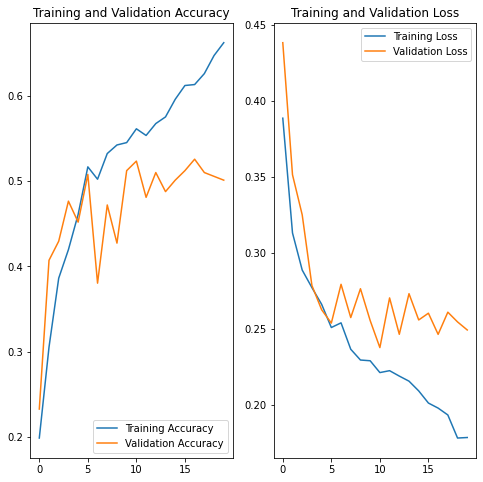

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [128]:
## Your code goes here.
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 22ms/step - loss: 0.2492 - accuracy: 0.5011
Training Accuracy:  0.7198660969734192
Validation Accuracy:  0.501118540763855
Loss:  0.15971480309963226
Validation Loss 0.24918286502361298


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Observation
Its observed that the accuracy results are more efficient than the previous model, lets see the classes distribution

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

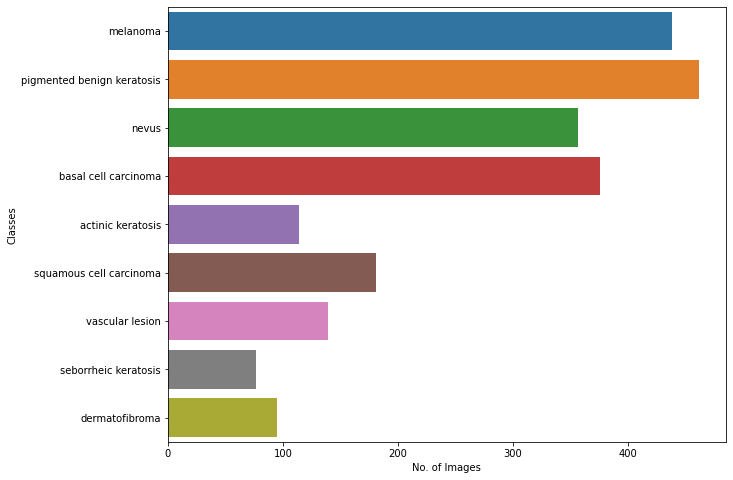

In [132]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Images", y="Classes", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? - Seborrheic keratosis has least samples less than 100
#### - Which classes dominate the data in terms proportionate number of samples? - Pigmented benign keratosis has more samples (more than 400) as per the distribution visual


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [133]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [135]:
# lets add some samples to the exisitng folders to handle data imbalance
path_to_training_dataset="/content/gdrive/MyDrive/upgrad
/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F905D1E63A0>: 100%|██████████| 500/500 [00:24<00:00, 20.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F90C00BBAF0>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F905D1419D0>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F905D05A550>: 100%|██████████| 500/500 [01:50<00:00,  4.52 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F903873E640>: 100%|██████████| 500/500 [01:39<00:00,  5.01 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F905D013640>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F905ADB5CD0>: 100%|██████████| 500/500 [00:48<00:00, 10.22 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F90D88BBE80>: 100%|██████████| 500/500 [00:22<00:00, 22.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F903873E1C0>: 100%|██████████| 500/500 [00:22<00:00, 21.83 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [136]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [137]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [138]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [139]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [140]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [141]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [142]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [143]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [144]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [7]:
## your code goes here
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

NameError: ignored

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [6]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

NameError: ignored

#### **Todo:**  Train your model

In [5]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: ignored

#### **Todo:**  Visualize the model results

In [3]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [4]:
## Your code goes here.
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

NameError: ignored

## Lets check what is the predicted cancer class

1/1 [==============================] - 0s 332ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


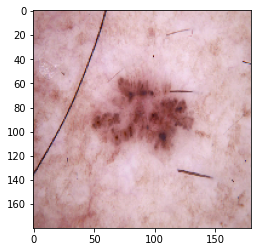

In [150]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




*   We could see a clear difference between the trainig acuracy and validation accuracy after the third model
*   Though the accuracy level became low when compare to first model but we redcued the loss completely
*  we tried to apply BatchNormalization and Augumenatation which helped to normalize data
*. Finally we cheked the predicted cancer class




